In [1]:
import scanpy as sc
import igraph as ig
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
import scipy.sparse as sp
from scipy.sparse.linalg import eigs
from tqdm import tqdm

from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import matplotlib as mpl

# Visualization of Gene Space with 10% HND Genes

## Data Preprocessing

In [2]:
adata = sc.read_h5ad('./data/hnd.h5ad')

In [3]:
if not isinstance(adata.X, np.ndarray):
    adata.X = adata.X.toarray()
adata

AnnData object with n_obs × n_vars = 604 × 13771
    obs: 'Sample_ID', 'Experiment', 'Day', 'Number of Alignments', 'Cell Quality Control', 'Outlier', 'Subpopulations', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'geneid', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [4]:
np.random.seed(42)
del_rate = 0.9
indices_to_delete = [False if np.random.rand()<del_rate else True for g in adata.var.index]
adata = adata[:, indices_to_delete]
adata

View of AnnData object with n_obs × n_vars = 604 × 1351
    obs: 'Sample_ID', 'Experiment', 'Day', 'Number of Alignments', 'Cell Quality Control', 'Outlier', 'Subpopulations', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'geneid', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [5]:
sc.pp.filter_cells(adata, min_genes=1)
sc.pp.filter_genes(adata, min_cells=1)

C:\Users\51895\AppData\Roaming\Python\Python38\site-packages\scanpy\preprocessing\_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number


In [6]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

## Calculating Complexity Index

In [7]:
def complexity_index(mcg):
    mgc = np.transpose(mcg)
    
    kc0 = np.sum(mcg, axis=1)
    kg0 = np.sum(mcg, axis=0)
    
    mcc = np.dot(mcg / np.transpose([kc0]), mgc / np.transpose([kg0]))
    
    e_val, e_vec = eigs(mcc)    
    cci = np.real(e_vec[:, 1])
    
    scc = ss.spearmanr(kc0, cci)[0]
    if scc < 0:
        cci = - cci
        
    gci = np.dot(mgc, np.transpose([cci])).flatten() / kg0
    
    cci = (cci - np.min(cci)) / (np.max(cci) - np.min(cci))
    gci = (gci - np.min(gci)) / (np.max(gci) - np.min(gci))
    
    return cci, gci

In [8]:
cci, gci = complexity_index(adata.X)

## Generating Gene Space

### Calculating  Revealed Comparative Advantage (RCA)

In [9]:
adata_c = np.sum(adata.X, axis=1)
adata_c = adata_c.reshape(-1, 1)
adata_g = np.sum(adata.X, axis=0)
adata_s = np.sum(adata.X)

rca = adata.X / adata_c / adata_g * adata_s

In [10]:
rca_th = rca.copy()
rca_th[rca_th < 1] = 0
rca_th[rca_th >= 1] = 1

### Calculating Proximity $\phi$

In [11]:
n_cell, n_gene = adata.X.shape
gene_proxim = np.dot(rca_th.transpose(), rca_th)
for i in tqdm(range(n_gene - 1)):
    for j in range(i+1, n_gene):
        gene_proxim[i, j] /= max(gene_proxim[i, i], gene_proxim[j, j])
        gene_proxim[j, i] = gene_proxim[i, j]
np.fill_diagonal(gene_proxim, 0)

100%|████████████████████████████████████████████████████████████████████████████| 1350/1350 [00:01<00:00, 1278.28it/s]


### Maximum Spanning Tree

In [12]:
gene_adjmat = sp.csc_matrix(gene_proxim)
gene_adjmat

<1351x1351 sparse matrix of type '<class 'numpy.float32'>'
	with 1823286 stored elements in Compressed Sparse Column format>

In [13]:
sources, targets = gene_adjmat.nonzero()
edgelist = list(zip(sources.tolist(), targets.tolist()))
g = ig.Graph(edgelist, edge_attrs={'weight': gene_adjmat.data.tolist()})
g.vs['id'] = g.vs.indices
g.to_undirected()

In [14]:
inv_weight = [1./w for w in g.es["weight"]]
g_maxtree = g.spanning_tree(weights=inv_weight)

## Visualization of Gene Space

In [15]:
visual_style = {}

visual_style['bbox'] = (500, 500)
visual_style['margin'] = 17
visual_style['vertex_size'] = 6
visual_style['vertex_label_size'] = 20
visual_style['edge_curved'] = False
visual_style['edge_width'] = 1.0
visual_style['vertex_frame_width'] = 0.5
visual_style['vertex_frame_color'] = 'black'

In [16]:
import random
random.seed(43)
layout = g_maxtree.layout_fruchterman_reingold()

In [17]:
g_maxtree.vs['color'] = '#90EE90'

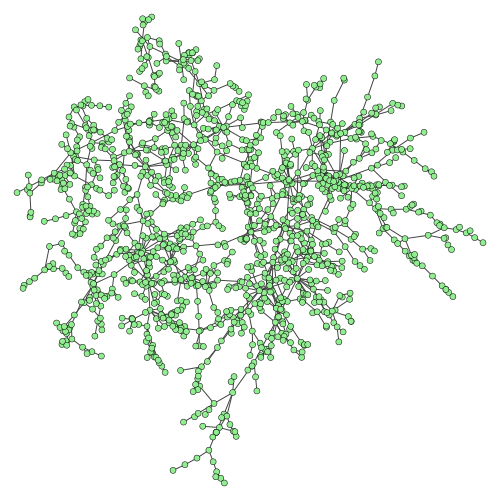

In [18]:
ig.plot(g_maxtree, layout=layout, **visual_style)

## Mapping Gene Expression Profiles of the Cell with Highest Complexity onto Gene Space

In [19]:
cell_order = np.argsort(cci)
cell_order = cell_order[::-1]

In [20]:
gene_color = '#FF7276'
null_color = '#90EE90'

In [21]:
cell_colors = []
nth_cell = cell_order[0]
for x in adata.X[nth_cell]:
    if x > 0:
        cell_colors.append(gene_color)
    else:
        cell_colors.append(null_color)

In [22]:
g_maxtree.vs['color'] = cell_colors
visual_style['edge_color'] = [g_maxtree.vs[es.source]['color'] for es in g_maxtree.es]

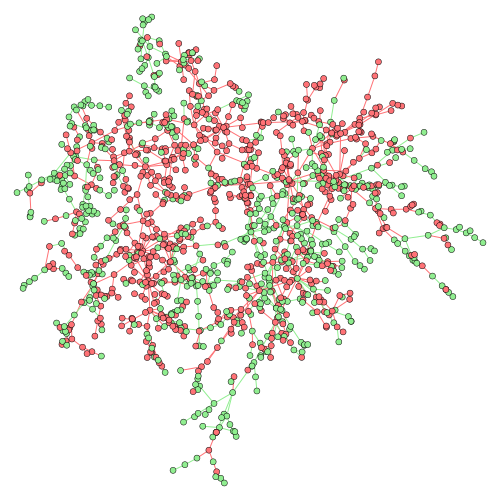

In [23]:
ig.plot(g_maxtree, layout=layout, **visual_style)

## Mapping Gene Expression Profiles of the Cell with Lowest Complexity onto Gene Space

In [24]:
cell_colors = []
nth_cell = cell_order[-1]
for x in adata.X[nth_cell]:
    if x > 0:
        cell_colors.append(gene_color)
    else:
        cell_colors.append(null_color)

In [25]:
g_maxtree.vs['color'] = cell_colors
visual_style['edge_color'] = [g_maxtree.vs[es.source]['color'] for es in g_maxtree.es]

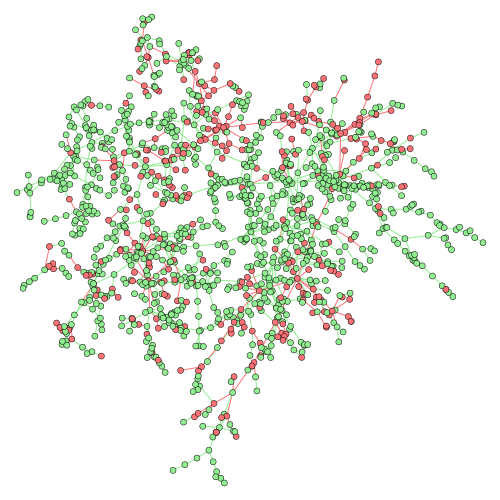

In [26]:
ig.plot(g_maxtree, layout=layout, **visual_style)

# Pearson Correlation Coefficients (PCC)

## Data Preprocessing

In [27]:
adata = sc.read_h5ad('./data/hnd.h5ad')

In [28]:
if not isinstance(adata.X, np.ndarray):
    adata.X = adata.X.toarray()
adata

AnnData object with n_obs × n_vars = 604 × 13771
    obs: 'Sample_ID', 'Experiment', 'Day', 'Number of Alignments', 'Cell Quality Control', 'Outlier', 'Subpopulations', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'geneid', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [29]:
sc.pp.filter_cells(adata, min_genes=1)
sc.pp.filter_genes(adata, min_cells=1)

In [30]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

In [31]:
obs_time = 'Day'
adata.obs['Day'].unique()
sorted_time = ['d0', 'd1', 'd5', 'd7', 'd10', 'd30']
adata.obs[obs_time] = adata.obs[obs_time].cat.reorder_categories(sorted_time)

In [32]:
time_unique = adata.obs[obs_time].unique()
time_dict = dict(zip(sorted_time, range(len(time_unique))))
time_order = [time_dict[t] for t in adata.obs[obs_time]]

reverse_list = [i for i in range(len(time_unique))]
reverse_list.reverse()
reverse_time_dict = dict(zip(sorted_time, reverse_list))
reverse_time_order = [reverse_time_dict[t] for t in adata.obs[obs_time]] 

## PCA Embedding

C:\Users\51895\AppData\Roaming\Python\Python38\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


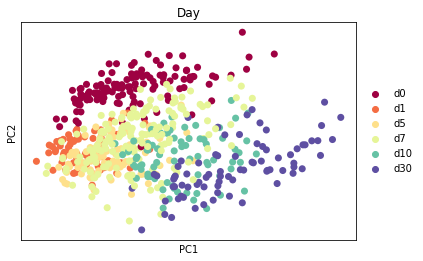

In [33]:
sc.tl.pca(adata)
sc.pl.pca(adata, color=obs_time, palette=plt.cm.Spectral.name)

## UMAP Embedding

C:\Users\51895\AppData\Roaming\Python\Python38\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


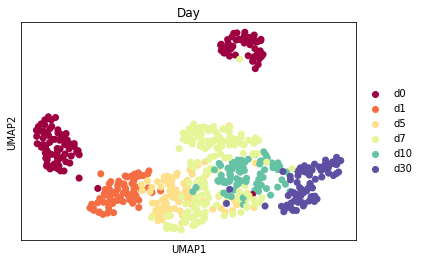

In [34]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=20)
sc.tl.umap(adata)
sc.pl.umap(adata, color=obs_time, palette=plt.cm.Spectral.name)

In [35]:
time_colors = dict(zip(sorted_time, adata.uns['{}_colors'.format(obs_time)]))

## Calculating Complexity Index

In [36]:
cci, gci = complexity_index(adata.X)

## Calculating CytoTRACE Pseudotime

In [37]:
import scvelo as scv
from cellrank.kernels import CytoTRACEKernel

sc.pp.highly_variable_genes(adata)
print(f"This detected {np.sum(adata.var['highly_variable'])} highly variable genes. ")

adata.layers["spliced"] = adata.X
adata.layers["unspliced"] = adata.X
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

ctk = CytoTRACEKernel(adata).compute_cytotrace()

This detected 2269 highly variable genes. 
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


## Generating Gene Space

### Calculating  Revealed Comparative Advantage (RCA)

In [38]:
adata_c = np.sum(adata.X, axis=1)
adata_c = adata_c.reshape(-1, 1)
adata_g = np.sum(adata.X, axis=0)
adata_s = np.sum(adata.X)

rca = adata.X / adata_c / adata_g * adata_s

In [39]:
rca_th = rca.copy()
rca_th[rca_th < 1] = 0
rca_th[rca_th >= 1] = 1

### Calculating Proximity $\phi$

In [40]:
n_cell, n_gene = adata.X.shape
gene_proxim = np.dot(rca_th.transpose(), rca_th)
for i in tqdm(range(n_gene - 1)):
    for j in range(i+1, n_gene):
        gene_proxim[i, j] /= max(gene_proxim[i, i], gene_proxim[j, j])
        gene_proxim[j, i] = gene_proxim[i, j]
np.fill_diagonal(gene_proxim, 0)

100%|███████████████████████████████████████████████████████████████████████████| 13770/13770 [01:52<00:00, 121.98it/s]


### Maximum Spanning Tree

In [41]:
gene_adjmat = sp.csc_matrix(gene_proxim)

In [42]:
gene_adjmat

<13771x13771 sparse matrix of type '<class 'numpy.float32'>'
	with 189541414 stored elements in Compressed Sparse Column format>

In [43]:
sources, targets = gene_adjmat.nonzero()
edgelist = list(zip(sources.tolist(), targets.tolist()))
g = ig.Graph(edgelist, edge_attrs={'weight': gene_adjmat.data.tolist()})
g.vs['id'] = g.vs.indices
g.to_undirected()

In [44]:
inv_weight = [1./w for w in g.es["weight"]]
g_maxtree = g.spanning_tree(weights=inv_weight)

## The Average Degree of Expressed Genes in Gene Space for Each Cell

In [45]:
cell_mean_degree = []
for i in tqdm(range(adata.X.shape[0])):
    sum_degree = 0
    n_gene = 0
    for j in range(adata.X.shape[1]):
        if adata.X[i, j] > 0:
            sum_degree += g_maxtree.degree(j)
            n_gene += 1
    cell_mean_degree.append(sum_degree/n_gene)

100%|████████████████████████████████████████████████████████████████████████████████| 604/604 [00:33<00:00, 17.81it/s]


## Assigning Cell Colors

In [46]:
colors = []
for day in adata.obs[obs_time]:
    colors.append(time_colors[day])

## Correlation of Gene Complexity and Network Degree

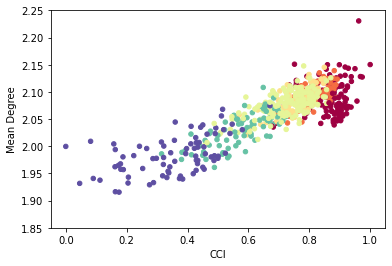

In [47]:
plt.scatter(cci, cell_mean_degree, s=20, c=colors, alpha=1.0)
plt.ylim(1.85, 2.25)
plt.xlabel('CCI')
plt.ylabel('Mean Degree')
plt.show()

In [48]:
ss.pearsonr(cci, cell_mean_degree)

PearsonRResult(statistic=0.8440828256319833, pvalue=4.428684322345066e-165)

## Correlation of  Expression Level and Network Degree

In [49]:
cell_gene_expression = np.sum(adata.X, axis=1)

minv = np.min(cell_gene_expression)
maxv = np.max(cell_gene_expression)
cell_gene_expression = (cell_gene_expression - minv) / (maxv - minv)

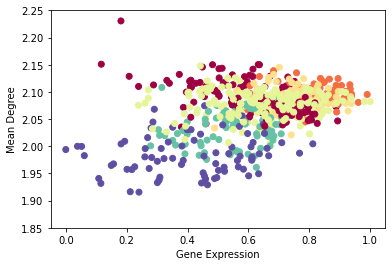

In [50]:
plt.scatter(cell_gene_expression, cell_mean_degree, c=colors)
plt.ylim(1.85, 2.25)
plt.xlabel('Gene Expression')
plt.ylabel('Mean Degree')
plt.show()

In [51]:
ss.pearsonr(cell_gene_expression, cell_mean_degree)

PearsonRResult(statistic=0.3900128468586035, pvalue=2.2240933947788692e-23)

## Correlation of CytoTRACE Score and Network Degree

In [52]:
ct_pseudotime = 1 - adata.obs['ct_pseudotime']
ct_pseudotime = ct_pseudotime.to_list()

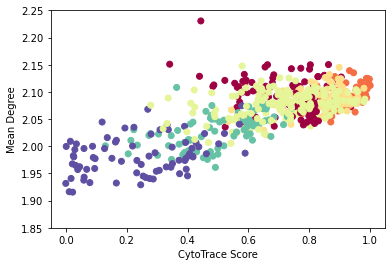

In [53]:
plt.scatter(ct_pseudotime, cell_mean_degree, c=colors)
plt.ylim(1.85, 2.25)
plt.xlabel('CytoTrace Score')
plt.ylabel('Mean Degree')
plt.show()

In [54]:
ss.pearsonr(ct_pseudotime, cell_mean_degree)

PearsonRResult(statistic=0.7331744168302359, pvalue=6.794048208577883e-103)